In [ ]:
import torch
from model_vae_1 import CVAE, cvae_loss
from vae_earlystopping import EarlyStopping
import numpy as np
import joblib
import pandas as pd

In [12]:
train_loader = torch.load('torch/train_loader.pt')
val_loader = torch.load('torch/val_loader.pt')
test_loader = torch.load('torch/test_loader.pt')

C:\Users\User\AppData\Local\Temp\ipykernel_15308\3444673415.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('torch/train_loader.pt')
C:\Users\U

In [13]:
x,c = next(iter(train_loader))
x_dim = x.shape[1]
c_dim = c.shape[1]
print(x_dim,c_dim)

23 9


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(x_dim=x_dim,c_dim = c_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [15]:
epochs = 300
loss_names = ["loss1", "loss2", "loss3", "loss4"]

train_losses = [[] for _ in range(4)]
val_losses   = [[] for _ in range(4)]

early = EarlyStopping(patience=30,min_delta =1e-4)
for epoch in range(1,epochs+1):
    model.train()
    total_train = [0.0, 0.0, 0.0,0.0]
    for x,c in train_loader:
        x = x.to(device)
        c = c.to(device)
        x_hat,mu,logvar = model(x,c)
        loss1,loss2,loss3,loss4, recon1,recon2,recon3,recon4, kl = cvae_loss(x_hat,x,mu,logvar,beta=0.01)
        losses = [loss1,loss2,loss3,loss4]
        optimizer.zero_grad()
        losses[3].backward() ## loss1에 대해서 진행
        optimizer.step()
        for i in range(4):
            total_train[i]+=losses[i].item()
    avg_train = [t / len(train_loader) for t in total_train]
    # validation
    model.eval()
    total_val = [0.0, 0.0, 0.0,0.0]
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)
            v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            v_loss1,v_loss2,v_loss3,v_loss4, v_recon1,v_recon2,v_recon3,v_recon4, v_kl = cvae_loss(v_x_hat,v_x,v_mu,v_logvar,beta = 0.01)
            v_losses = [v_loss1, v_loss2, v_loss3,v_loss4]
            for i in range(4):
                total_val[i] += v_losses[i].item()
    avg_val = [t / len(val_loader) for t in total_val]
    for i in range(4):
        train_losses[i].append(avg_train[i])
        val_losses[i].append(avg_val[i])

    if epoch % 20 == 0 or epoch ==2:
        print(f"[{epoch}/{epochs}] train {loss_names[3]}:{avg_train[3]:.4f}")
        print(f"[{epoch}/{epochs}] val   {loss_names[3]}:{avg_val[3]:.4f}")
    
    # earlystopping 같은경우에는 avg_val_loss1으로 해서 진행
    stop= early.step(avg_val[3],model)
    if early.best_state is not None and avg_val[3] == early.best:
        best_epoch = epoch
    if stop:
        print(f'Early_stopping at {epoch},best_epoch = {best_epoch}, val_loss:{early.best:.4f}')
        break


[2/300] train loss4:0.0246
[2/300] val   loss4:0.0248
[20/300] train loss4:0.0126
[20/300] val   loss4:0.0128
[40/300] train loss4:0.0116
[40/300] val   loss4:0.0114
[60/300] train loss4:0.0115
[60/300] val   loss4:0.0117
[80/300] train loss4:0.0110
[80/300] val   loss4:0.0115
Early_stopping at 97,best_epoch = 67, val_loss:0.0110


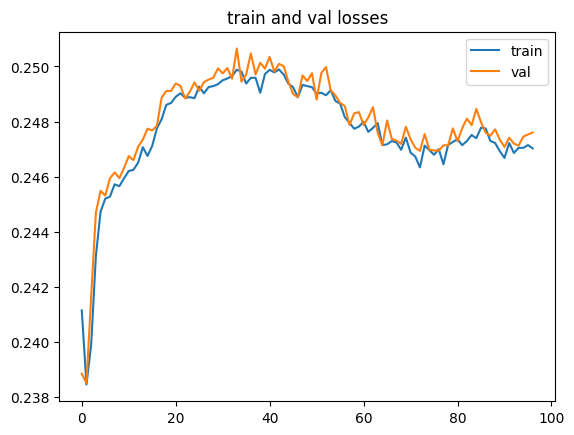

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_losses[0],label ='train')
plt.plot(val_losses[0], label = 'val')
plt.title('train and val losses')
plt.legend()
plt.show()

In [17]:
model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

x_true_list = []
x_hat_list = []

with torch.no_grad():
    for x_test, c_test in test_loader:
        x_test = x_test.to(device)
        c_test = c_test.to(device)

        x_hat_test, test_mu, test_logvar = model(x_test, c_test)

        x_true_np = x_test.detach().cpu().numpy()
        x_hat_np = x_hat_test.detach().cpu().numpy()

        x_true_list.append(x_true_np)
        x_hat_list.append(x_hat_np)

x_true_test_np = np.concatenate(x_true_list, axis=0)
x_hat_test_np  = np.concatenate(x_hat_list, axis=0)
x_scaler = joblib.load('./torch/x_scaler.pkl')
x_true_test = x_scaler.inverse_transform(x_true_test_np)
x_hat_test  = x_scaler.inverse_transform(x_hat_test_np)

print(x_true_test.shape, x_hat_test.shape)


(1182, 23) (1182, 23)


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

rmse = np.sqrt(mean_squared_error(x_true_test, x_hat_test))
mse = mean_squared_error(x_true_test,x_hat_test)
r2 = r2_score(x_true_test.flatten(),x_hat_test.flatten())
print(f'rmse: {rmse:.4f},r2: {r2:.4f}')

rmse: 4.5577,r2: -6.0426


In [19]:
## Ni 함량에 대해서 고민하기 
## Ni 피처의 유무 따져보기()

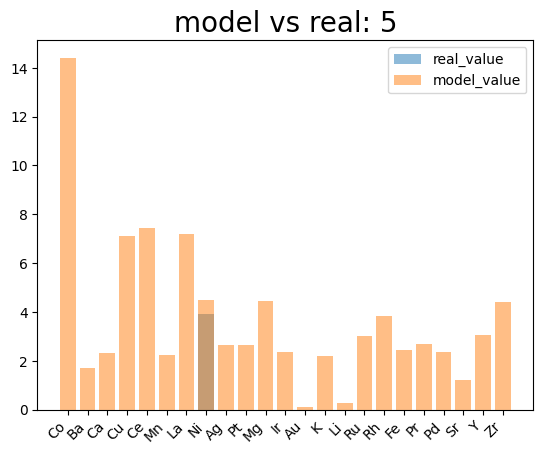

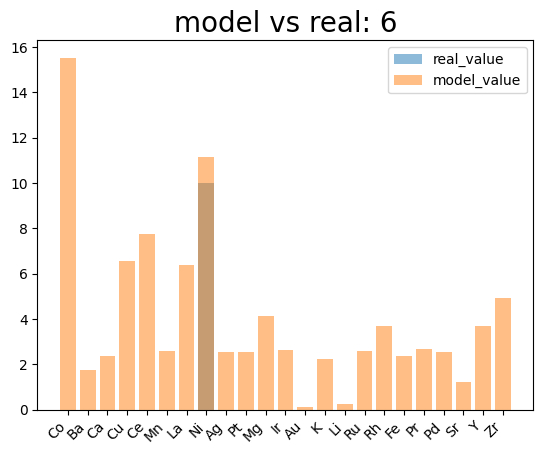

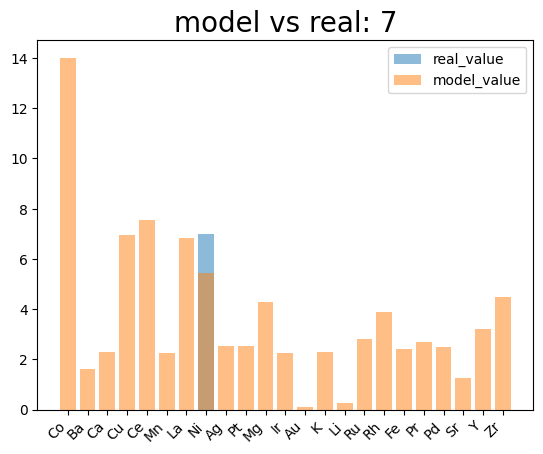

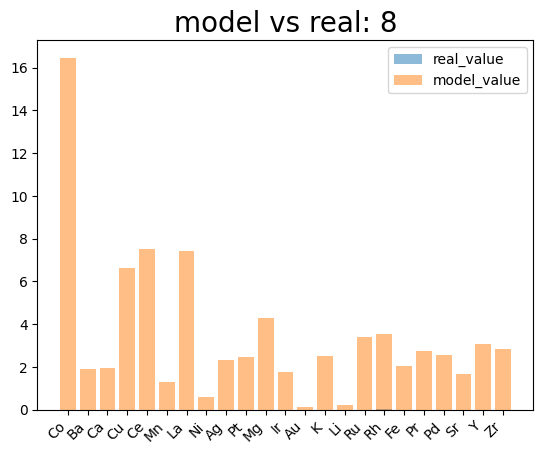

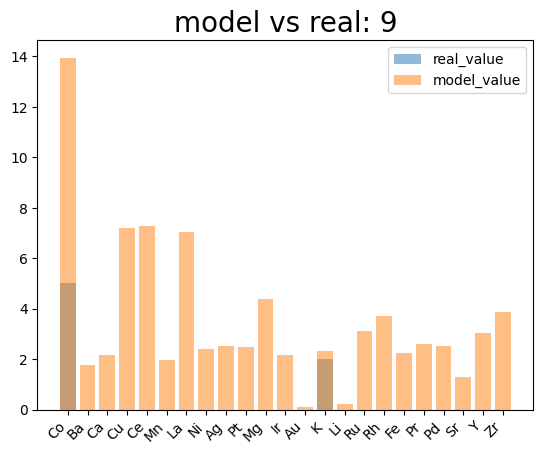

In [20]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,2:25].columns
for i in range(5,10):
    plt.bar(metal_columns, x_true_test[i],label = 'real_value',alpha = 0.5)
    plt.bar(metal_columns,x_hat_test[i],label = 'model_value', alpha=0.5)
    plt.xticks(rotation=45,ha='right')
    plt.title(f'model vs real: {i}',fontsize = 20)
    plt.legend()
    plt.show()